# Word2Vec(skip gram)

In [1]:
import tensorflow as tf
import numpy as np
import os

In [2]:
samples = ["철수은 축구를 좋아한다",
          "영희은 축구를 싫어한다",
          "철수은 도서관을 좋아한다",
          "영희은 도서관을 싫어한다",
          "철수은 공부를 좋아한다",
          "영희은 공부를 싫어한다",
          "철수은 축구를 좋아한다 영희은 축구를 싫어한다"]

In [3]:
from tensorflow.keras import preprocessing

tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(samples) 
sequences = tokenizer.texts_to_sequences(samples) 

word_to_index = tokenizer.word_index

In [4]:
index_to_word = dict((i, w) for w, i in word_to_index.items())
print(index_to_word)

{1: '철수은', 2: '축구를', 3: '좋아한다', 4: '영희은', 5: '싫어한다', 6: '도서관을', 7: '공부를'}


In [6]:
skip_gram_data = []
print(f'sequences: {sequences}')

for sequence in sequences:
    for i in range(1, len(sequence) - 1):
        context = sequence[i]
        target = sequence[i - 1]
        skip_gram_data.append([target, context])
        target = sequence[i+1]
        skip_gram_data.append([target, context])
        
print(f'skip_gram_data\n{skip_gram_data}')

sequences: [[1, 2, 3], [4, 2, 5], [1, 6, 3], [4, 6, 5], [1, 7, 3], [4, 7, 5], [1, 2, 3, 4, 2, 5]]
skip_gram_data
[[1, 2], [3, 2], [4, 2], [5, 2], [1, 6], [3, 6], [4, 6], [5, 6], [1, 7], [3, 7], [4, 7], [5, 7], [1, 2], [3, 2], [2, 3], [4, 3], [3, 4], [2, 4], [4, 2], [5, 2]]


In [7]:
context = []
target = []
for i in range(len(skip_gram_data)):
    context.append(skip_gram_data[i][0])  # context
    target.append(skip_gram_data[i][1])  # label

In [8]:
def mapping_fn(context, target):
    features = {"context": context}
    return features, target

In [9]:
EPOCH_SIZE = 1500
BATCH_SIZE = 2

def train_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((context, target))
    dataset = dataset.repeat(EPOCH_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.shuffle(len(skip_gram_data))
    dataset = dataset.map(mapping_fn)

    return dataset

In [10]:
VOCAB_SIZE = len(word_to_index) + 1
EMB_SIZE = 128

def model_fn(features, labels, mode):
    
    w_1 = tf.Variable(tf.random_uniform([VOCAB_SIZE, EMB_SIZE], -1.0, 1.0)) #(10, 2)
    w_2 = tf.Variable(tf.random_uniform([EMB_SIZE, VOCAB_SIZE], -1.0, 1.0)) #(2, 10)

    context = tf.one_hot(indices=features['context'], depth=VOCAB_SIZE) #(?, 10)
    
    hidden = tf.matmul(context, w_1)

    output = tf.matmul(hidden, w_2) # (?, 2)*(2, 10) = (?, 10)
                                   
    targets = tf.one_hot(indices=labels, depth=VOCAB_SIZE)  
                                                            
    loss = tf.losses.softmax_cross_entropy(targets, output)

    global_step = tf.train.get_global_step()
    train_op = tf.train.AdamOptimizer(1e-3).minimize(loss, global_step)


    return tf.estimator.EstimatorSpec(
          mode=mode,
          train_op=train_op,
          loss=loss)

In [11]:
DATA_OUT_PATH = './data_out/'

if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)

estimator = tf.estimator.Estimator(model_fn = model_fn, model_dir = DATA_OUT_PATH + 'checkpoint/skip_gram')

In [12]:
tf.logging.set_verbosity(tf.logging.INFO)

In [13]:
estimator.train(train_input_fn)

W0831 01:18:25.737586 4681942464 deprecation.py:323] From /Users/chojunghyun/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/training/training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
I0831 01:18:25.775840 4681942464 estimator.py:1145] Calling model_fn.
W0831 01:18:25.813663 4681942464 deprecation.py:323] From /Users/chojunghyun/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
I0831 01:18:25.877351 4681942464 estimator.py:1147] Done calling model_f

I0831 01:18:27.712866 4681942464 basic_session_run_hooks.py:260] loss = 2.002514, step = 3401 (0.044 sec)
I0831 01:18:27.754029 4681942464 basic_session_run_hooks.py:692] global_step/sec: 2382.59
I0831 01:18:27.754703 4681942464 basic_session_run_hooks.py:260] loss = 1.4161478, step = 3501 (0.042 sec)
I0831 01:18:27.797722 4681942464 basic_session_run_hooks.py:692] global_step/sec: 2289
I0831 01:18:27.798540 4681942464 basic_session_run_hooks.py:260] loss = 1.2546675, step = 3601 (0.044 sec)
I0831 01:18:27.840996 4681942464 basic_session_run_hooks.py:692] global_step/sec: 2310.69
I0831 01:18:27.841768 4681942464 basic_session_run_hooks.py:260] loss = 1.5030037, step = 3701 (0.043 sec)
I0831 01:18:27.883385 4681942464 basic_session_run_hooks.py:692] global_step/sec: 2358.99
I0831 01:18:27.884088 4681942464 basic_session_run_hooks.py:260] loss = 0.8571882, step = 3801 (0.042 sec)
I0831 01:18:27.925336 4681942464 basic_session_run_hooks.py:692] global_step/sec: 2383.7
I0831 01:18:27.92603

I0831 01:18:29.570513 4681942464 basic_session_run_hooks.py:260] loss = 1.6980708, step = 7601 (0.045 sec)
I0831 01:18:29.616171 4681942464 basic_session_run_hooks.py:692] global_step/sec: 2153.47
I0831 01:18:29.617091 4681942464 basic_session_run_hooks.py:260] loss = 1.4169452, step = 7701 (0.047 sec)
I0831 01:18:29.660654 4681942464 basic_session_run_hooks.py:692] global_step/sec: 2246.98
I0831 01:18:29.661424 4681942464 basic_session_run_hooks.py:260] loss = 0.7297051, step = 7801 (0.044 sec)
I0831 01:18:29.702243 4681942464 basic_session_run_hooks.py:692] global_step/sec: 2404.49
I0831 01:18:29.702949 4681942464 basic_session_run_hooks.py:260] loss = 0.9954741, step = 7901 (0.042 sec)
I0831 01:18:29.744786 4681942464 basic_session_run_hooks.py:692] global_step/sec: 2350.28
I0831 01:18:29.745501 4681942464 basic_session_run_hooks.py:260] loss = 1.1184871, step = 8001 (0.043 sec)
I0831 01:18:29.787955 4681942464 basic_session_run_hooks.py:692] global_step/sec: 2316.59
I0831 01:18:29.

I0831 01:18:31.407073 4681942464 basic_session_run_hooks.py:260] loss = 1.195015, step = 11801 (0.041 sec)
I0831 01:18:31.446509 4681942464 basic_session_run_hooks.py:692] global_step/sec: 2491.58
I0831 01:18:31.447203 4681942464 basic_session_run_hooks.py:260] loss = 1.6308267, step = 11901 (0.040 sec)
I0831 01:18:31.486838 4681942464 basic_session_run_hooks.py:692] global_step/sec: 2479.67
I0831 01:18:31.487565 4681942464 basic_session_run_hooks.py:260] loss = 1.3013184, step = 12001 (0.040 sec)
I0831 01:18:31.527626 4681942464 basic_session_run_hooks.py:692] global_step/sec: 2451.52
I0831 01:18:31.528321 4681942464 basic_session_run_hooks.py:260] loss = 0.8342742, step = 12101 (0.041 sec)
I0831 01:18:31.571521 4681942464 basic_session_run_hooks.py:692] global_step/sec: 2278.27
I0831 01:18:31.572212 4681942464 basic_session_run_hooks.py:260] loss = 1.0703999, step = 12201 (0.044 sec)
I0831 01:18:31.615298 4681942464 basic_session_run_hooks.py:692] global_step/sec: 2284.24
I0831 01:18

In [14]:
variable_names = estimator.get_variable_names()

In [15]:
variable_names

['Variable',
 'Variable/Adam',
 'Variable/Adam_1',
 'Variable_1',
 'Variable_1/Adam',
 'Variable_1/Adam_1',
 'beta1_power',
 'beta2_power',
 'global_step']

In [16]:
embdding_matrix = estimator.get_variable_value(variable_names[0])

In [17]:
embdding_matrix

array([[ 0.8028474 ,  0.85521436,  0.5184512 , ..., -0.60787606,
        -0.6954031 , -0.46987796],
       [-0.4420694 , -0.649924  , -0.14036438, ..., -0.6803831 ,
         0.28558588, -0.5069637 ],
       [-0.880475  ,  0.57259476,  0.34701905, ..., -0.6269412 ,
         0.7958463 , -0.83279026],
       ...,
       [-0.5300158 ,  0.575054  ,  0.31964675, ...,  0.43842757,
         0.92096287, -0.04506041],
       [-0.89772224,  0.18824673, -0.85243344, ..., -0.08613658,
        -0.5065973 , -0.8063369 ],
       [ 0.87899256, -0.27922177, -0.87606883, ..., -0.4657266 ,
        -0.75240445, -0.09334016]], dtype=float32)

### 임베딩 그림 그리기

In [18]:
%matplotlib inline  

import matplotlib.pyplot as plt  

In [19]:
from sklearn.manifold import TSNE

In [21]:
import matplotlib.font_manager as fm  

In [22]:
path = './NanumBarunGothic.ttf'
fontprop = fm.FontProperties(fname=path, size=12)

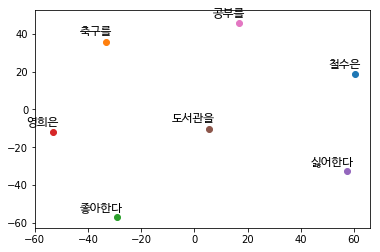

In [23]:
model = TSNE(learning_rate=100)
transformed = model.fit_transform(embdding_matrix)

xs = transformed[:,0]
ys = transformed[:,1]

for i, offset in enumerate(transformed[1:]):
    x, y = offset
    plt.scatter(x, y)
    plt.annotate(index_to_word[i+1], xy=(x, y), xytext=(6, 4),
                 textcoords='offset points', ha='right', va='bottom', fontproperties=fontprop)

plt.show()